In [2]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import PyPDFLoader
import os


In [ ]:
llm = ChatNVIDIA(
    model="meta/llama3-70b-instruct",
    nvidia_api_key="NVIDIA_API_KEY",
    temperature=0.3
)

embedding = NVIDIAEmbeddings(
    model="nvidia/nv-embedqa-e5-v5",
    model_type="passage",
    nvidia_api_key= "NVIDIA_API_KEY"
)


pdf_path = "C:\\Users\\Akshar Savaliya\\Downloads\\Agentic_NN.pdf"
loader = PyPDFLoader(pdf_path)
documents = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100).split_documents(loader.load())
vectorstore = Chroma.from_documents(documents, embedding, persist_directory="D:\\Corp8.AI\\Rag_Types")

In [4]:
class GraphState(TypedDict):
    question: str
    retrieved_docs: List[dict]
    graded_docs: List[dict]
    answer: str
    hallucination_verdict: str
    answer_verdict: str
    retry_count: int
    force_end: bool
    last_node: str 

In [5]:
def retrieve(state: GraphState):
    docs = vectorstore.similarity_search(state["question"], k=4)
    return {**state, "retrieved_docs": docs, "last_node": "retrieve"}

def grade(state: GraphState):
    for doc in state["retrieved_docs"]:
        content = doc.page_content.lower()
        doc.metadata['score'] = 1.0 if any(k in content for k in ["agentic", "ann", "backpropagation"]) else 0.3
    return {**state, "graded_docs": state["retrieved_docs"], "last_node": "grade"}

def check_docs_relevant(state: GraphState):
    if not state["graded_docs"]:
        return "rewrite"
    avg = sum(d.metadata['score'] for d in state["graded_docs"]) / len(state["graded_docs"])
    return "generate" if avg >= 0.5 else "rewrite"

In [6]:
def generate(state: GraphState):
    context = "\n".join([d.page_content for d in state["graded_docs"]])
    prompt = f"""You are an expert AI assistant. Answer using ONLY the context. Say "I don't know" if unsure.

Context:
{context}

Question: {state['question']}

Answer:"""
    res = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "answer": res.content, "last_node": "generate"}

def hallucination_check(state: GraphState):
    context = "\n".join([d.page_content for d in state["graded_docs"]])
    prompt = f"""Is this answer fully supported by the context? Reply only 'yes' or 'no'.

Context:
{context}
Answer: {state['answer']}

Verdict:"""
    res = llm.invoke([HumanMessage(content=prompt)])
    verdict = "pass" if "yes" in res.content.lower() else "fail"
    return {**state, "hallucination_verdict": verdict, "last_node": "hallucination_check"}

def check_answer_fits_question(state: GraphState):
    prompt = f"""Does this answer fully address the question? Reply only 'yes' or 'no'.

Question: {state['question']}
Answer: {state['answer']}

Verdict:"""
    res = llm.invoke([HumanMessage(content=prompt)])
    return {**state, "answer_verdict": "final" if "yes" in res.content.lower() else "rewrite", "last_node": "check_answer"}

def rewrite_question(state: GraphState):
    if state["retry_count"] >= 1:
        return {**state, "answer_verdict": "final", "force_end": True, "last_node": "rewrite"}

    prompt = f"Improve this question to be more specific and answerable:\nOriginal: {state['question']}\nImproved:"
    res = llm.invoke([HumanMessage(content=prompt)])
    return {
        **state,
        "question": res.content.strip(),
        "retry_count": state["retry_count"] + 1,
        "force_end": False,
        "last_node": "rewrite"
    }

def check_retry_limit(state: GraphState):
    return "end" if state["force_end"] else "retrieve"

In [7]:
graph = StateGraph(GraphState)

graph.add_node("retrieve", retrieve)
graph.add_node("grade", grade)
graph.add_node("generate", generate)
graph.add_node("rewrite", rewrite_question)
graph.add_node("hallucination_check", hallucination_check)
graph.add_node("check_answer", check_answer_fits_question)

graph.set_entry_point("retrieve")

graph.add_edge("retrieve", "grade")
graph.add_conditional_edges("grade", check_docs_relevant, {
    "generate": "generate",
    "rewrite": "rewrite"
})
graph.add_edge("generate", "hallucination_check")
graph.add_conditional_edges("hallucination_check", lambda s: s["hallucination_verdict"], {
    "pass": "check_answer",
    "fail": "rewrite"
})
graph.add_conditional_edges("check_answer", lambda s: s["answer_verdict"], {
    "final": END,
    "rewrite": "rewrite"
})
graph.add_conditional_edges("rewrite", lambda s: "END" if s["force_end"] else "retrieve", {
    "END": END,
    "retrieve": "retrieve"
})


app = graph.compile()

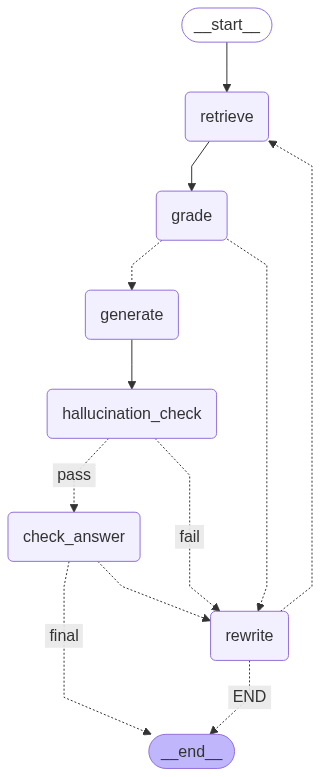

In [8]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [9]:

initial_state = {
    "question": "What is Agentic Neural Networks?",
    "retrieved_docs": [],
    "graded_docs": [],
    "answer": "",
    "hallucination_verdict": "",
    "answer_verdict": "",
    "retry_count": 0,
    "force_end": False,
    "last_node": ""
}

result = app.invoke(initial_state, config={"recursion_limit": 15})
print("\n=== FINAL ANSWER ===")
print(result["answer"])


=== FINAL ANSWER ===
Here's an explanation of Agentic Neural Networks (ANNs), including their architecture, applications, and how they differ from traditional neural networks:

Architecture:
The architecture of ANNs is inspired by traditional neural networks, where each layer consists of nodes represented by agents. These agents are connected in a sequence, facilitating seamless information flow from one layer to the next. This modular yet interconnected design enables efficient data processing, flexibility, and adaptability.

The agents in ANNs are designed to work together, combining their outputs to produce the final result. This is achieved through dynamic routing and aggregation, where the optimal aggregation function is selected for each layer based on the input data.

Applications:
The applications of ANNs are not explicitly stated in the provided context. However, based on the architecture and design, it can be inferred that ANNs are suitable for complex data processing tasks 